In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, metrics
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from datetime import datetime
import lightgbm
import seaborn as sns
import xgboost

from sklearn import neural_network
from scipy.stats import hmean

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
tqdm_notebook().pandas()

In [3]:
df = pd.read_csv("/Users/aakashkerawat/autoML/wns_adclick/train.csv")

In [4]:
df_t = pd.read_csv("/Users/aakashkerawat/autoML/wns_adclick/test.csv")

In [5]:
df_v = pd.read_csv("/Users/aakashkerawat/autoML/wns_adclick/view_log.csv")
df_i = pd.read_csv("/Users/aakashkerawat/autoML/wns_adclick/item_data.csv")

In [6]:
df["impression_time"] = pd.to_datetime(df["impression_time"], format="%Y-%m-%d %H:%M:%S")
df_t["impression_time"] = pd.to_datetime(df_t["impression_time"], format="%Y-%m-%d %H:%M:%S")
df_v["server_time"] = pd.to_datetime(df_v["server_time"], format="%Y-%m-%d %H:%M:%S")

In [7]:
df_v = df_v.sort_values(["user_id", "server_time"]).reset_index(drop=True)

## Full df

In [8]:
df_v["dummy_ones"] = 1

In [9]:
df_v["visit_number"] = df_v.groupby("user_id")["dummy_ones"].cumsum()

In [10]:
session_number = df_v.groupby("user_id")["session_id"].expanding().progress_apply(lambda x: len(np.unique(x)))

session_number.set_axis(df_v.index)

df_v["session_number"] = session_number

/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm.py:660: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  result = getattr(df, df_function)(wrapper, **kwargs)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
item_number = df_v.groupby("user_id")["item_id"].expanding().progress_apply(lambda x: len(np.unique(x)))

item_number.set_axis(df_v.index)

df_v["item_number"] = item_number

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
views_cols = ["user_id", "server_time","visit_number", "session_number", "item_number"]

In [13]:
df = df.sort_values("impression_time").reset_index(drop=True)

In [14]:
df_t = df_t.sort_values("impression_time").reset_index(drop=True)

### Train test split fe

In [15]:
df_v_tr = df_v.loc[df_v["server_time"]<datetime(2018, 12, 3)].reset_index(drop=True)

In [16]:
df_tr = df.loc[df["impression_time"]<datetime(2018, 12, 3)].reset_index(drop=True)
df_te = df.loc[df["impression_time"]>=datetime(2018, 12, 3)].reset_index(drop=True)

In [17]:
df_v_tr = df_v_tr.sort_values(["server_time"]).reset_index(drop=True)

In [18]:
df_v = df_v.sort_values(["server_time"]).reset_index(drop=True)

In [19]:
df_f_tr = pd.merge_asof(left=df_tr, right=df_v_tr[views_cols], left_on="impression_time", right_on="server_time", direction="backward", by=["user_id"])

df_f_te = pd.merge_asof(left=df_te, right=df_v_tr[views_cols], left_on="impression_time", right_on="server_time", direction="backward", by=["user_id"])

In [20]:
df_f = pd.merge_asof(left=df, right=df_v[views_cols], left_on="impression_time", right_on="server_time", direction="backward", by=["user_id"])

df_ft = pd.merge_asof(left=df_t, right=df_v[views_cols], left_on="impression_time", right_on="server_time", direction="backward", by=["user_id"])

In [21]:
def generate_combined_features(df_train, df_test):
    train_ids = df_train["impression_id"].unique()
    test_ids = df_test["impression_id"].unique()
    df_combined = pd.concat([df_train ,df_test]).reset_index(drop=True)
    df_combined["impression_time_hour"] =  df_combined["impression_time"].dt.hour
    df_combined["impression_time_dom"] =  df_combined["impression_time"].dt.day

    df_combined = df_combined.sort_values(["user_id", "impression_time"]).reset_index(drop=True)

    df_combined["user_click_ewm"] = df_combined.groupby("user_id")["is_click"].progress_apply(lambda x: x.ewm(alpha=0.9).mean().shift())

    df_combined["user_click_ewm2"] = df_combined.groupby("user_id")["is_click"].progress_apply(lambda x: x.ewm(alpha=0.7).mean().shift())

    df_combined["dummy_ones"] = 1
    df_combined["n_ad_seen"] = df_combined.groupby("user_id")["dummy_ones"].cumsum()
    del df_combined["dummy_ones"]

    df_combined["prev_add_seen_days_ago"] = ((df_combined["impression_time"]-df_combined["impression_time"].shift()).dt.seconds)/60

    user_same = df_combined["user_id"]==df_combined["user_id"].shift()
    df_combined.loc[~user_same, "prev_add_seen_days_ago"] = np.nan

    df_combined["prev_click_sum"] = df_combined.groupby("user_id")["is_click"].progress_apply(lambda x: x.expanding().sum().shift())

    df_combined["time_since_ads_started"] = ((df_combined["impression_time"]-df_combined["user_id"].map(df_combined.groupby("user_id")["impression_time"].min())).dt.total_seconds())/60

    df_combined = df_combined.sort_values(["app_code", "impression_time"]).reset_index(drop=True)

    df_combined["dummy_ones"] = 1
    df_combined["app_code_count_n"] = df_combined.groupby("app_code")["dummy_ones"].cumsum()
    del df_combined["dummy_ones"]

    df_combined["app_click_ewm"] = df_combined.groupby("app_code")["is_click"].progress_apply(lambda x: x.ewm(alpha=0.6).mean().shift())

    df_combined["prev_app_click"] = df_combined.groupby("app_code")["is_click"].progress_apply(lambda x: x.expanding().mean().shift())

    df_combined["prev_app_click_sum"] = df_combined.groupby("app_code")["is_click"].progress_apply(lambda x: x.expanding().sum().shift())

    df_combined = df_combined.sort_values(["impression_time"]).reset_index(drop=True)

    df_combined["prev_user_app_click_mean"] = df_combined.groupby(["user_id", "app_code"])["is_click"].progress_apply(lambda x: x.expanding().mean().shift())
    
    df_train = df_combined.loc[df_combined["impression_id"].isin(train_ids)].reset_index(drop=True)
    df_test = df_combined.loc[df_combined["impression_id"].isin(test_ids)].reset_index(drop=True)
    return df_train ,df_test

In [22]:
df_f_tr, df_f_te = generate_combined_features(df_f_tr, df_f_te)

In [23]:
df_f, df_ft = generate_combined_features(df_f, df_ft)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [24]:
def generate_count_feats(df_train, df_test):
    df_train["user_count_leak"] = df_train["user_id"].map(df_train["user_id"].value_counts())
    df_test["user_count_leak"] = df_test["user_id"].map(df_train["user_id"].value_counts())

    df_train["app_count_leak"] = df_train["app_code"].map(df_train["app_code"].value_counts())
    df_test["app_count_leak"] = df_test["app_code"].map(df_train["app_code"].value_counts())
    return df_train, df_test

In [25]:
df_f_tr, df_f_te = generate_count_feats(df_f_tr, df_f_te)
df_f, df_ft = generate_count_feats(df_f, df_ft)

In [26]:
predictors = df_f_tr.columns.drop(["impression_id", "impression_time","is_click", "server_time",
                                    "os_version", "user_id", "app_code", "session_number", "item_number", "time_since_ads_started"])

In [27]:
predictors

Index(['is_4G', 'visit_number', 'impression_time_hour', 'impression_time_dom',
       'user_click_ewm', 'user_click_ewm2', 'n_ad_seen',
       'prev_add_seen_days_ago', 'prev_click_sum', 'app_code_count_n',
       'app_click_ewm', 'prev_app_click', 'prev_app_click_sum',
       'prev_user_app_click_mean', 'user_count_leak', 'app_count_leak'],
      dtype='object')

In [28]:
len(predictors)

16

In [29]:
lgb = lightgbm.LGBMClassifier(n_estimators=650, max_depth=5, learning_rate=0.005, colsample_bytree=0.6, random_state=2019)

In [30]:
lgb.fit(df_f_tr[predictors], df_f_tr["is_click"])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
        importance_type='split', learning_rate=0.005, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=650, n_jobs=-1, num_leaves=31, objective=None,
        random_state=2019, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [31]:
preds = lgb.predict_proba(df_f_te[predictors])[:,1]
preds_tr = lgb.predict_proba(df_f_tr[predictors])[:,1]

In [32]:
metrics.roc_auc_score(df_f_tr["is_click"], preds_tr), metrics.roc_auc_score(df_f_te["is_click"], preds)

(0.7491758398634748, 0.7435771493923812)

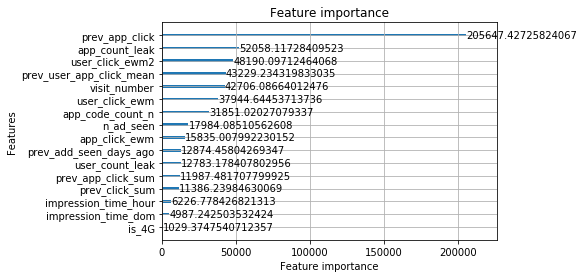

In [33]:
lightgbm.plot_importance(lgb, importance_type="gain")

In [34]:
nn = neural_network.MLPClassifier(hidden_layer_sizes=(25, 10), verbose=1, random_state=1000)

In [35]:
scaler = preprocessing.StandardScaler()

In [36]:
df_f_tr_filled = df_f_tr.copy()
df_f_te_filled = df_f_te.copy()

In [37]:
for col in predictors:
    mean_ = df_f_tr[col].mean()
    print(col)
    df_f_tr_filled[col] = df_f_tr_filled[col].fillna(mean_)
    df_f_te_filled[col] = df_f_te_filled[col].fillna(mean_)

is_4G
visit_number
impression_time_hour
impression_time_dom
user_click_ewm
user_click_ewm2
n_ad_seen
prev_add_seen_days_ago
prev_click_sum
app_code_count_n
app_click_ewm
prev_app_click
prev_app_click_sum
prev_user_app_click_mean
user_count_leak
app_count_leak


In [38]:
tr_sc = scaler.fit_transform(df_f_tr_filled[predictors])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [39]:
te_sc = scaler.transform(df_f_te_filled[predictors])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [40]:
nn.fit(tr_sc, df_f_tr["is_click"])

Iteration 1, loss = 0.22083339
Iteration 2, loss = 0.17349259
Iteration 3, loss = 0.17240066
Iteration 4, loss = 0.17179769
Iteration 5, loss = 0.17139478
Iteration 6, loss = 0.17107568
Iteration 7, loss = 0.17101772
Iteration 8, loss = 0.17089016
Iteration 9, loss = 0.17071538
Iteration 10, loss = 0.17061604
Iteration 11, loss = 0.17051365
Iteration 12, loss = 0.17045071
Iteration 13, loss = 0.17034039
Iteration 14, loss = 0.17034513
Iteration 15, loss = 0.17021090
Iteration 16, loss = 0.17018129
Iteration 17, loss = 0.17016966
Iteration 18, loss = 0.17005310
Iteration 19, loss = 0.17001507
Iteration 20, loss = 0.17005453
Iteration 21, loss = 0.17002015
Iteration 22, loss = 0.16982289
Iteration 23, loss = 0.16988119
Iteration 24, loss = 0.16989444
Iteration 25, loss = 0.16983195
Iteration 26, loss = 0.16976187
Iteration 27, loss = 0.16974876
Iteration 28, loss = 0.16975847
Iteration 29, loss = 0.16969730
Iteration 30, loss = 0.16951427
Iteration 31, loss = 0.16955108
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(25, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1000, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [41]:
preds = nn.predict_proba(te_sc)[:,1]
preds_tr = nn.predict_proba(tr_sc)[:,1]

In [42]:
metrics.roc_auc_score(df_f_tr["is_click"], preds_tr), metrics.roc_auc_score(df_f_te["is_click"], preds)

(0.7315617760449162, 0.7297852262448479)

### Final training

In [43]:
df_f_filled = df_f.copy()
df_ft_filled = df_ft.copy()

In [44]:
for col in predictors:
    mean_ = df_f[col].mean()
    print(col)
    df_f_filled[col] = df_f_filled[col].fillna(mean_)
    df_ft_filled[col] = df_ft_filled[col].fillna(mean_)

is_4G
visit_number
impression_time_hour
impression_time_dom
user_click_ewm
user_click_ewm2
n_ad_seen
prev_add_seen_days_ago
prev_click_sum
app_code_count_n
app_click_ewm
prev_app_click
prev_app_click_sum
prev_user_app_click_mean
user_count_leak
app_count_leak


In [45]:
tr_f_sc = scaler.fit_transform(df_f_filled[predictors])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [46]:
te_f_sc = scaler.transform(df_ft_filled[predictors])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [47]:
all_preds = pd.DataFrame(index=df_ft.index)
for seed_ in np.arange(1000, 1021):
    print(seed_)
    nn = neural_network.MLPClassifier(hidden_layer_sizes=(25, 10), verbose=1, random_state=seed_)
    nn.fit(tr_f_sc, df_f["is_click"])
    all_preds["nn_seed_{}".format(seed_)] = nn.predict_proba(te_f_sc)[:,1]

1000
Iteration 1, loss = 0.20521954
Iteration 2, loss = 0.17247245
Iteration 3, loss = 0.17164836
Iteration 4, loss = 0.17126577
Iteration 5, loss = 0.17099261
Iteration 6, loss = 0.17089058
Iteration 7, loss = 0.17080486
Iteration 8, loss = 0.17072739
Iteration 9, loss = 0.17060419
Iteration 10, loss = 0.17052461
Iteration 11, loss = 0.17043661
Iteration 12, loss = 0.17039701
Iteration 13, loss = 0.17031689
Iteration 14, loss = 0.17027241
Iteration 15, loss = 0.17019154
Iteration 16, loss = 0.17008047
Iteration 17, loss = 0.17006118
Iteration 18, loss = 0.17005557
Iteration 19, loss = 0.16995113
Iteration 20, loss = 0.16990861
Iteration 21, loss = 0.16993281
Iteration 22, loss = 0.16987339
Iteration 23, loss = 0.16988444
Iteration 24, loss = 0.16981340
Iteration 25, loss = 0.16977543
Iteration 26, loss = 0.16970418
Iteration 27, loss = 0.16975709
Iteration 28, loss = 0.16969352
Iteration 29, loss = 0.16966912
Iteration 30, loss = 0.16960936
Training loss did not improve more than tol=

Iteration 22, loss = 0.16962330
Iteration 23, loss = 0.16954494
Iteration 24, loss = 0.16953435
Iteration 25, loss = 0.16951496
Iteration 26, loss = 0.16943978
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
1009
Iteration 1, loss = 0.19651662
Iteration 2, loss = 0.17204132
Iteration 3, loss = 0.17137885
Iteration 4, loss = 0.17110277
Iteration 5, loss = 0.17094105
Iteration 6, loss = 0.17081154
Iteration 7, loss = 0.17069066
Iteration 8, loss = 0.17061285
Iteration 9, loss = 0.17057615
Iteration 10, loss = 0.17049845
Iteration 11, loss = 0.17041165
Iteration 12, loss = 0.17039059
Iteration 13, loss = 0.17036522
Iteration 14, loss = 0.17026730
Iteration 15, loss = 0.17029466
Iteration 16, loss = 0.17023509
Iteration 17, loss = 0.17017364
Iteration 18, loss = 0.17013081
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
1010
Iteration 1, loss = 0.20221411
Iteration 2, loss = 0.17306329
Iteration 3, loss = 0

Iteration 12, loss = 0.17023575
Iteration 13, loss = 0.17014700
Iteration 14, loss = 0.17017069
Iteration 15, loss = 0.17010353
Iteration 16, loss = 0.17006761
Iteration 17, loss = 0.16996633
Iteration 18, loss = 0.17002188
Iteration 19, loss = 0.16998802
Iteration 20, loss = 0.16991175
Iteration 21, loss = 0.16985111
Iteration 22, loss = 0.16984778
Iteration 23, loss = 0.16980473
Iteration 24, loss = 0.16981069
Iteration 25, loss = 0.16974122
Iteration 26, loss = 0.16963696
Iteration 27, loss = 0.16970887
Iteration 28, loss = 0.16965395
Iteration 29, loss = 0.16958346
Iteration 30, loss = 0.16959817
Iteration 31, loss = 0.16961791
Iteration 32, loss = 0.16955215
Iteration 33, loss = 0.16952206
Iteration 34, loss = 0.16946453
Iteration 35, loss = 0.16944990
Iteration 36, loss = 0.16942375
Iteration 37, loss = 0.16940545
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
1019
Iteration 1, loss = 0.21184052
Iteration 2, loss = 0.17323735
Iteration 3

In [48]:
all_preds.shape

(90675, 21)

In [49]:
# all_preds = pd.DataFrame(index=df_ft.index)
for seed_ in np.arange(1000, 1021):
    print(seed_)
    lgb = lightgbm.LGBMClassifier(n_estimators=650, max_depth=5, learning_rate=0.005, colsample_bytree=0.6, random_state=seed_)
    lgb.fit(df_f[predictors], df_f["is_click"])
    all_preds["lgb_seed_{}".format(seed_)] = lgb.predict_proba(df_ft[predictors])[:,1]

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020


In [50]:
nn_cols = [col for col in all_preds if col.startswith("nn")]
lgb_cols = [col for col in all_preds if col.startswith("lgb")]

In [51]:
all_preds.shape

(90675, 42)

In [52]:
preds_t = hmean((all_preds[nn_cols].mean(1), all_preds[lgb_cols].mean(1).values))

In [53]:
sub = pd.DataFrame({"impression_id":df_ft.impression_id.values, "is_click":preds_t})

In [54]:
sub.to_csv("sub_2.csv", index=False)